In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adagrad
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.utils import to_categorical
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Google Drive'da veri setimin bulunduğu ana dizin
data_dir = '/content/drive/My Drive/dataset'

In [ ]:
# Veri artırma için ImageDataGenerator kullanma
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  # ResNet-50 için veri ön işleme işlevini kullanma
)

In [ ]:
# Train veri yükleyici
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'training_set'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 8010 images belonging to 2 classes.


In [ ]:
# Sınıf sayısını belirt
num_classes = len(train_generator.class_indices)

In [ ]:
# One-hot encoding işlemi
onehot_encoder = OneHotEncoder(sparse=False)
y_onehot = to_categorical(train_generator.classes, num_classes=num_classes)

In [ ]:
# Veriyi eğitim ve validasyon setlerine ayırma
X_train, X_val, y_train, y_val = train_test_split(train_generator.filenames, y_onehot, test_size=0.2, random_state=42)

In [ ]:
# Veri setini yükleyin ve resimleri, etiketleri ile birlikte alın
train_data = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': X_train, 'category': np.argmax(y_train, axis=1)}),
    directory=os.path.join(data_dir, 'training_set'),
    x_col='filename',
    y_col='category',
    target_size=(150, 150),
    batch_size=32,
    class_mode='raw'  # 'binary' yerine 'raw' kullandım
)

val_data = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': X_val, 'category': np.argmax(y_val, axis=1)}),
    directory=os.path.join(data_dir, 'training_set'),
    x_col='filename',
    y_col='category',
    target_size=(150, 150),
    batch_size=32,
    class_mode='raw'  # 'binary' yerine 'raw' kullandım
)

Found 6408 validated image filenames.
Found 1602 validated image filenames.


In [ ]:
# Model oluşturma

# ResNet-50 modelini yükleme
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


# Modelin üstüne özel sınıflandırma katmanlarını ekleme
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=output_layer)

# Sadece eklenen katmanları eğitilebilir yapma (fine-tuning)
for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
# Erken durdurma (EarlyStopping) ve Model Kontrol Noktası (ModelCheckpoint) geri çağrıları
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

In [ ]:
# Modeli derleme
model.compile(loss='categorical_crossentropy', optimizer=Adagrad(learning_rate=0.01), metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
# Adagrad optimizörü kullanımı

In [ ]:
# Modeli eğitme
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=train_generator,  # Validation verisi olarak train_generator'ı kullanabilirsin
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/30
251/251 [==============================] - ETA: 0s - loss: 0.1736 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428
Epoch 1: val_loss improved from inf to 0.05453, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


251/251 [==============================] - 2054s 8s/step - loss: 0.1736 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - val_loss: 0.0545 - val_accuracy: 0.9794 - val_precision: 0.9794 - val_recall: 0.9794
Epoch 2/30
251/251 [==============================] - ETA: 0s - loss: 0.0847 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670
Epoch 2: val_loss improved from 0.05453 to 0.04546, saving model to best_model.h5
251/251 [==============================] - 72s 288ms/step - loss: 0.0847 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - val_loss: 0.0455 - val_accuracy: 0.9843 - val_precision: 0.9843 - val_recall: 0.9843
Epoch 3/30
251/251 [==============================] - ETA: 0s - loss: 0.0667 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744
Epoch 3: val_loss improved from 0.04546 to 0.03730, saving model to best_model.h5
251/251 [==============================] - 58s 231ms/step - loss: 0.0667 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - val_loss

In [ ]:
# Eğitim sonuçlarını saklama
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']
validation_accuracy = history.history['accuracy']
validation_loss = history.history['loss']
validation_precision = history.history['precision']
validation_recall = history.history['recall']

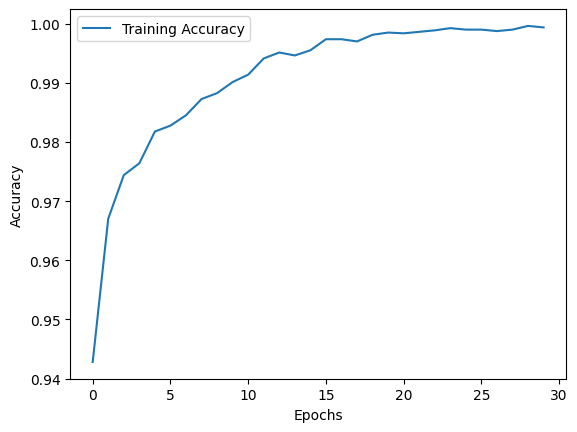

In [ ]:
# Eğitim sonuçlarını görselleştirme
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Test verisi için veri yükleyici oluşturma
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'test_set'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 2000 images belonging to 2 classes.


In [ ]:
# Modelin test verisi üzerinde performansını ölçme
test_metrics = model.evaluate(test_generator, return_dict=True)
print("Test Metrics:", test_metrics)

63/63 [==============================] - 486s 8s/step - loss: 0.8251 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.5000
Test Metrics: {'loss': 0.8251274824142456, 'accuracy': 0.5, 'precision': 0.5, 'recall': 0.5}


In [ ]:
# Precision ve Recall hesaplamaları
test_predictions = model.predict(test_generator)
test_predictions_classes = np.argmax(test_predictions, axis=1)

true_labels = test_generator.classes

precision = precision_score(true_labels, test_predictions_classes, average='weighted')
recall = recall_score(true_labels, test_predictions_classes, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")

63/63 [==============================] - 8s 112ms/step
Precision: 0.25
Recall: 0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Test verisi için veri yükleyici oluşturma
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'test_set'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'  # İkili sınıflandırma
)

Found 2000 images belonging to 2 classes.


In [ ]:
# Test verisi üzerinde tahminler yapma
predictions = model.predict(test_generator)

63/63 [==============================] - 8s 109ms/step


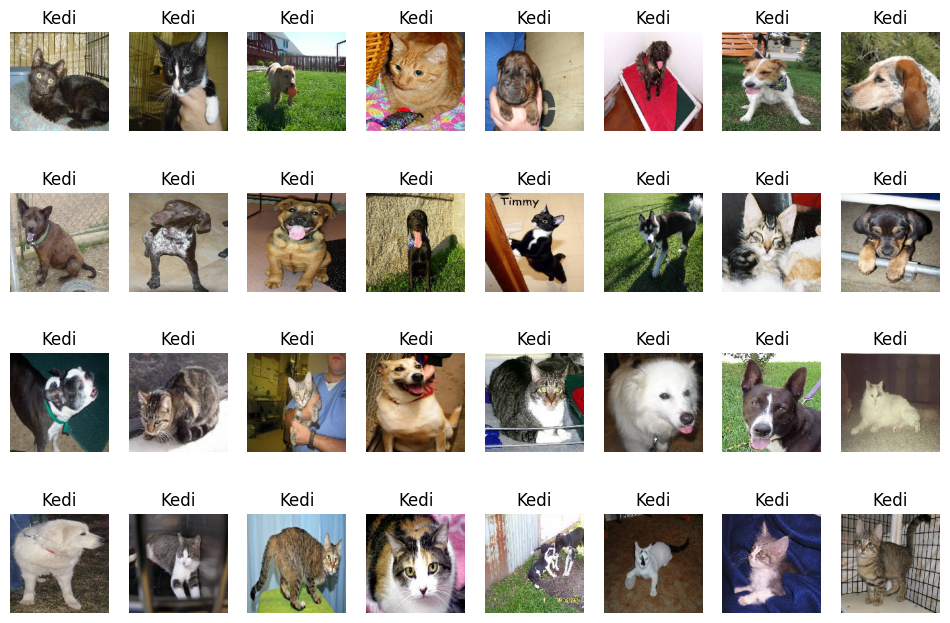

In [ ]:
# Test verisi üzerinde tahmin sonuçlarını görselleştirme
plt.figure(figsize=(12, 8))

for i in range(len(predictions)):
    if i >= 32:
        break

    plt.subplot(4, 8, i + 1)
    plt.imshow(test_generator[i][0][0])
    plt.axis('off')

    predicted_class = np.argmax(predictions[i])
    if predicted_class == 1:
        plt.title("Köpek")
    else:
        plt.title("Kedi")

plt.show()